# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# comment this out if you're not on a  multi-gpu config
# I am also utilizing the swish activation function for better results
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

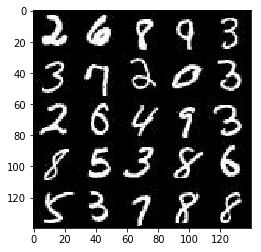

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

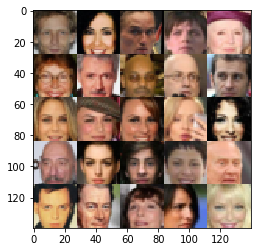

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data, learning_rate placeholder)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels])
    z_input_ = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    lr_ = tf.placeholder(dtype=tf.float32, shape=None)
    
    return input_, z_input_, lr_


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, infer=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.dropout(conv1, 0.3, training=infer)
        conv1 = tf.maximum(conv1, conv1 * alpha)
        #conv1 = conv1*tf.nn.sigmoid(conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.layers.dropout(conv2, 0.3, training=infer)
        conv2 = tf.maximum(conv2, conv2 * alpha)
        #conv2 = conv2 * tf.nn.sigmoid(conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.layers.dropout(conv3, 0.3, training=infer)
        conv3 = tf.maximum(conv3, conv3 * alpha)
        #conv3 = conv3 * tf.nn.sigmoid(conv3)

        flat = tf.reshape(conv3,  shape=[-1,256*4*4])
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        #logits = tf.layers.dropout(logits, 0.5)
        output = tf.nn.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    infer = is_train
    with tf.variable_scope('generator', reuse=not is_train):
        layer0 = tf.layers.dense(z, 4*4*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer0 = tf.reshape(layer0, [-1, 4, 4, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        #layer0 = tf.maximum(layer0, alpha*layer0)
        layer0 = layer0 * tf.nn.sigmoid(layer0)
        
        # different shapes to make this layer 7x7
        conv0 = tf.layers.conv2d_transpose(layer0, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv0 = tf.layers.batch_normalization(conv0, training=is_train)
        conv0 = tf.layers.dropout(conv0, 0.1, training=infer)
        #conv0 = tf.maximum(conv0, conv0*alpha)
        conv0 = conv0 * tf.nn.sigmoid(conv0)
        
        conv1 = tf.layers.conv2d_transpose(conv0, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.layers.dropout(conv1, 0.1, training=infer)
        #conv1 = tf.maximum(conv1, conv1 * alpha)
        conv1 = conv1 * tf.nn.sigmoid(conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())

        output = tf.nn.tanh(conv2)
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
   
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)* 0.1))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    tf_vars = tf.trainable_variables()
    
    d_vars = [var for var in tf_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in tf_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 1 if data_image_mode == "L" else 3
    input_real, input_z, lr_ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train, g_train = model_opt(d_loss, g_loss, lr_, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _, _ = sess.run([d_train, g_train], feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                sess.run(g_train, feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                #sess.run(g_train, feed_dict={input_real:batch_images, input_z:batch_z, lr_:learning_rate})
                if step % 50 == 0:
                    d_loss_var, g_loss_var = sess.run([d_loss, g_loss], feed_dict={input_real:batch_images, input_z:batch_z})
                    print("Epoch {}: Step:{} d_loss:{} g_loss:{}".format(epoch_i, step, d_loss_var, g_loss_var))
                if step%150 ==0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
            #print("Epoch Finished with Generator Loss at {} and D Loss at {}".format())
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0: Step:0 d_loss:4.766788005828857 g_loss:0.015367049723863602


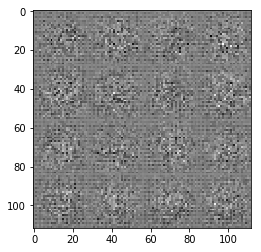

Epoch 0: Step:50 d_loss:1.8910740613937378 g_loss:0.4727865755558014
Epoch 0: Step:100 d_loss:1.709777593612671 g_loss:0.6041872501373291
Epoch 0: Step:150 d_loss:1.4156360626220703 g_loss:0.7964383363723755


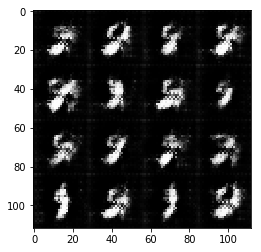

Epoch 0: Step:200 d_loss:1.6713850498199463 g_loss:0.5394513607025146
Epoch 0: Step:250 d_loss:1.604648232460022 g_loss:0.7716699838638306
Epoch 0: Step:300 d_loss:1.5514097213745117 g_loss:0.5494335889816284


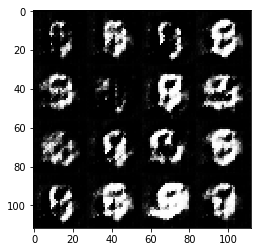

Epoch 0: Step:350 d_loss:1.3750865459442139 g_loss:0.6436464190483093
Epoch 0: Step:400 d_loss:1.5176564455032349 g_loss:0.685578465461731
Epoch 0: Step:450 d_loss:1.3878668546676636 g_loss:0.7445322275161743


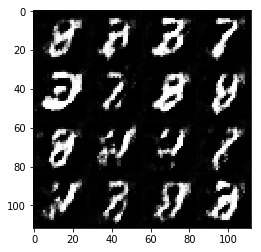

Epoch 0: Step:500 d_loss:1.478735089302063 g_loss:0.6373941898345947
Epoch 0: Step:550 d_loss:1.4720163345336914 g_loss:0.6578280329704285
Epoch 0: Step:600 d_loss:1.4576823711395264 g_loss:0.5758942365646362


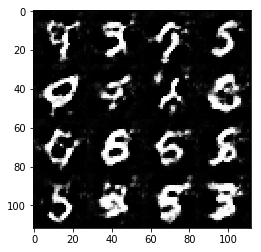

Epoch 0: Step:650 d_loss:1.4620466232299805 g_loss:0.6358140707015991
Epoch 0: Step:700 d_loss:1.4786421060562134 g_loss:0.6574890613555908
Epoch 0: Step:750 d_loss:1.4801344871520996 g_loss:0.6199349761009216


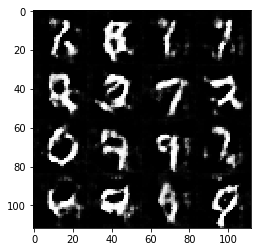

Epoch 0: Step:800 d_loss:1.4304494857788086 g_loss:0.6664012670516968
Epoch 0: Step:850 d_loss:1.4429244995117188 g_loss:0.7366414070129395
Epoch 0: Step:900 d_loss:1.4303383827209473 g_loss:0.6270110011100769


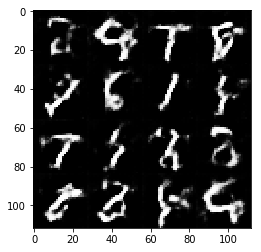

Epoch 0: Step:950 d_loss:1.4905116558074951 g_loss:0.6725115776062012
Epoch 0: Step:1000 d_loss:1.454007863998413 g_loss:0.6373775005340576
Epoch 0: Step:1050 d_loss:1.3924243450164795 g_loss:0.6306822896003723


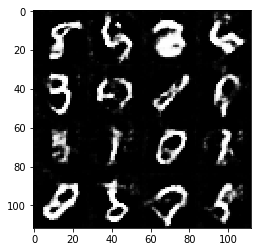

Epoch 0: Step:1100 d_loss:1.4274580478668213 g_loss:0.6111164689064026
Epoch 0: Step:1150 d_loss:1.3928637504577637 g_loss:0.7788833379745483
Epoch 0: Step:1200 d_loss:1.46775484085083 g_loss:0.6684941649436951


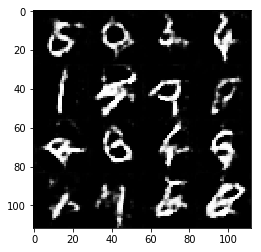

Epoch 0: Step:1250 d_loss:1.4457954168319702 g_loss:0.6532472372055054
Epoch 0: Step:1300 d_loss:1.4323300123214722 g_loss:0.6056947708129883
Epoch 0: Step:1350 d_loss:1.4516491889953613 g_loss:0.6961965560913086


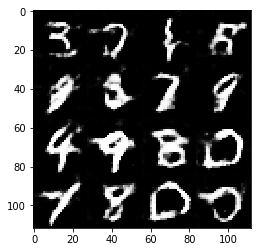

Epoch 0: Step:1400 d_loss:1.4003520011901855 g_loss:0.7377974987030029
Epoch 0: Step:1450 d_loss:1.4293596744537354 g_loss:0.6814662218093872
Epoch 0: Step:1500 d_loss:1.4102702140808105 g_loss:0.683754026889801


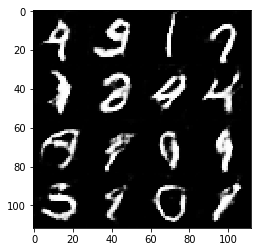

Epoch 0: Step:1550 d_loss:1.4053666591644287 g_loss:0.6960922479629517
Epoch 0: Step:1600 d_loss:1.4595541954040527 g_loss:0.7102398872375488
Epoch 0: Step:1650 d_loss:1.5444340705871582 g_loss:0.48873305320739746


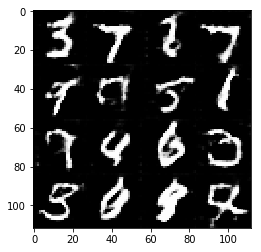

Epoch 0: Step:1700 d_loss:1.4314473867416382 g_loss:0.6038875579833984
Epoch 0: Step:1750 d_loss:1.4056251049041748 g_loss:0.7431975603103638
Epoch 0: Step:1800 d_loss:1.4479764699935913 g_loss:0.5745773315429688


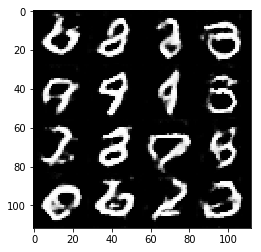

Epoch 0: Step:1850 d_loss:1.4542005062103271 g_loss:0.5985481142997742
Epoch 1: Step:0 d_loss:1.4835809469223022 g_loss:0.5540653467178345


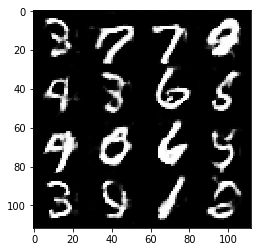

Epoch 1: Step:50 d_loss:1.5144002437591553 g_loss:0.5337586402893066
Epoch 1: Step:100 d_loss:1.4102963209152222 g_loss:0.9125922918319702
Epoch 1: Step:150 d_loss:1.4885022640228271 g_loss:0.5614225268363953


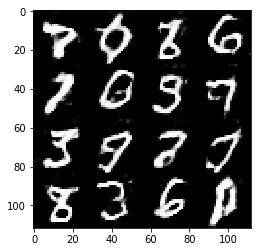

Epoch 1: Step:200 d_loss:1.4540246725082397 g_loss:0.7489911317825317
Epoch 1: Step:250 d_loss:1.4886417388916016 g_loss:0.9613239765167236
Epoch 1: Step:300 d_loss:1.3897830247879028 g_loss:0.7492929697036743


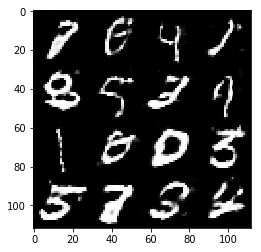

Epoch 1: Step:350 d_loss:1.420499324798584 g_loss:0.7010899782180786
Epoch 1: Step:400 d_loss:1.4017536640167236 g_loss:0.6837013363838196
Epoch 1: Step:450 d_loss:1.3668272495269775 g_loss:0.7015343308448792


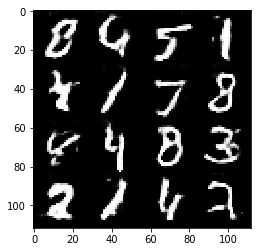

Epoch 1: Step:500 d_loss:1.3862398862838745 g_loss:0.7031392455101013
Epoch 1: Step:550 d_loss:1.3632135391235352 g_loss:0.6313621997833252
Epoch 1: Step:600 d_loss:1.531214952468872 g_loss:0.5755420327186584


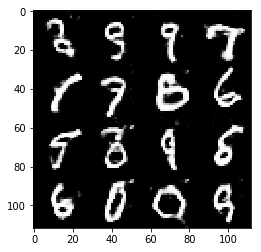

Epoch 1: Step:650 d_loss:1.4541237354278564 g_loss:0.5486308336257935
Epoch 1: Step:700 d_loss:1.4358761310577393 g_loss:0.582711935043335
Epoch 1: Step:750 d_loss:1.6068775653839111 g_loss:0.401455283164978


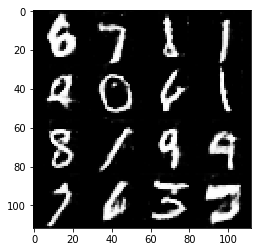

Epoch 1: Step:800 d_loss:1.4299160242080688 g_loss:0.7076253890991211
Epoch 1: Step:850 d_loss:1.5612380504608154 g_loss:0.4147492051124573
Epoch 1: Step:900 d_loss:1.4448473453521729 g_loss:0.6259679794311523


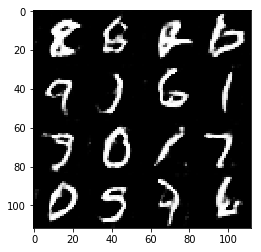

Epoch 1: Step:950 d_loss:1.4825770854949951 g_loss:0.6133301258087158
Epoch 1: Step:1000 d_loss:1.459153175354004 g_loss:0.5763680934906006
Epoch 1: Step:1050 d_loss:1.395603895187378 g_loss:0.7108080387115479


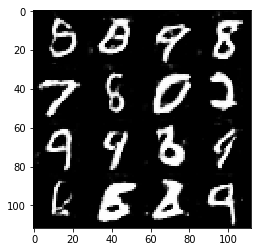

Epoch 1: Step:1100 d_loss:1.4182370901107788 g_loss:0.8624585866928101
Epoch 1: Step:1150 d_loss:1.40445876121521 g_loss:0.6134040355682373
Epoch 1: Step:1200 d_loss:1.4739553928375244 g_loss:0.6998929977416992


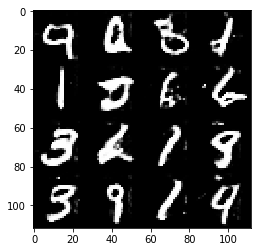

Epoch 1: Step:1250 d_loss:1.3937450647354126 g_loss:0.6111067533493042
Epoch 1: Step:1300 d_loss:1.445176601409912 g_loss:0.6306467056274414
Epoch 1: Step:1350 d_loss:1.3642557859420776 g_loss:0.6636993288993835


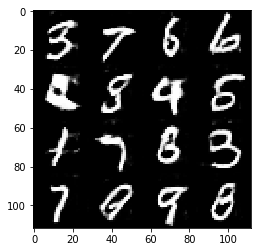

Epoch 1: Step:1400 d_loss:1.4275404214859009 g_loss:0.4897536635398865
Epoch 1: Step:1450 d_loss:2.025317668914795 g_loss:1.694240927696228
Epoch 1: Step:1500 d_loss:1.3978331089019775 g_loss:0.8342410922050476


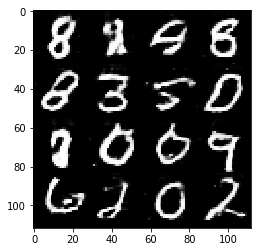

Epoch 1: Step:1550 d_loss:1.4370357990264893 g_loss:0.5396099090576172
Epoch 1: Step:1600 d_loss:1.625868320465088 g_loss:0.32390785217285156
Epoch 1: Step:1650 d_loss:1.3671975135803223 g_loss:0.7529020309448242


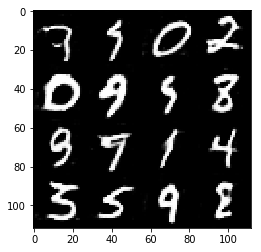

Epoch 1: Step:1700 d_loss:1.4244143962860107 g_loss:0.5203699469566345
Epoch 1: Step:1750 d_loss:1.3931403160095215 g_loss:0.6062620878219604
Epoch 1: Step:1800 d_loss:1.4026843309402466 g_loss:0.633548378944397


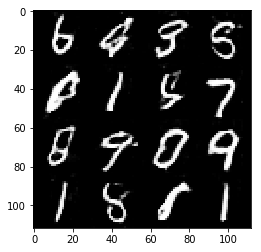

Epoch 1: Step:1850 d_loss:1.5467604398727417 g_loss:0.3973388075828552


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0: Step:0 d_loss:2.3522772789001465 g_loss:0.1991303265094757


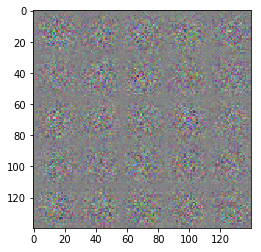

Epoch 0: Step:50 d_loss:1.3751490116119385 g_loss:0.8375310897827148
Epoch 0: Step:100 d_loss:1.0940990447998047 g_loss:1.2495875358581543
Epoch 0: Step:150 d_loss:1.297988772392273 g_loss:1.0103615522384644


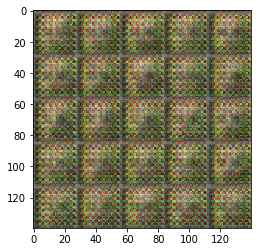

Epoch 0: Step:200 d_loss:1.1644210815429688 g_loss:1.0593254566192627
Epoch 0: Step:250 d_loss:1.2011585235595703 g_loss:1.1658848524093628
Epoch 0: Step:300 d_loss:1.0614323616027832 g_loss:1.2626245021820068


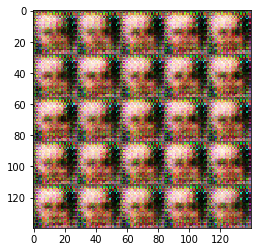

Epoch 0: Step:350 d_loss:0.8389249444007874 g_loss:1.5674844980239868
Epoch 0: Step:400 d_loss:0.8764520883560181 g_loss:1.6349968910217285
Epoch 0: Step:450 d_loss:1.1567939519882202 g_loss:1.0585620403289795


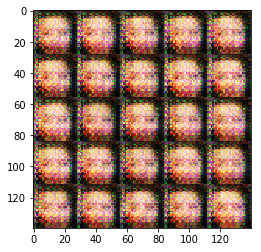

Epoch 0: Step:500 d_loss:1.0707310438156128 g_loss:1.4588003158569336
Epoch 0: Step:550 d_loss:1.2367597818374634 g_loss:1.355018138885498
Epoch 0: Step:600 d_loss:0.8809380531311035 g_loss:1.7163705825805664


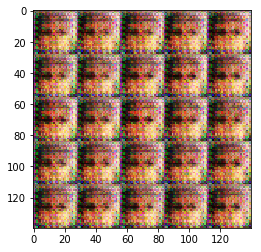

Epoch 0: Step:650 d_loss:0.9702651500701904 g_loss:1.3838379383087158
Epoch 0: Step:700 d_loss:0.7724035382270813 g_loss:1.857926368713379
Epoch 0: Step:750 d_loss:0.927298903465271 g_loss:1.4208238124847412


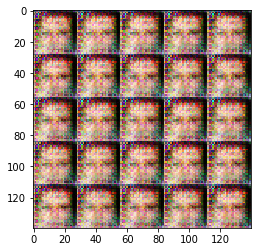

Epoch 0: Step:800 d_loss:0.8153000473976135 g_loss:1.9715616703033447
Epoch 0: Step:850 d_loss:1.0798041820526123 g_loss:1.7357392311096191
Epoch 0: Step:900 d_loss:1.3828141689300537 g_loss:0.770114004611969


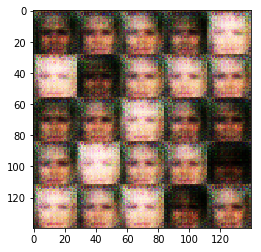

Epoch 0: Step:950 d_loss:1.2539416551589966 g_loss:0.8609758615493774
Epoch 0: Step:1000 d_loss:1.0656354427337646 g_loss:1.1040072441101074
Epoch 0: Step:1050 d_loss:1.4770398139953613 g_loss:0.9070130586624146


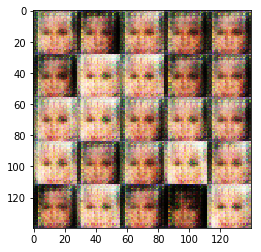

Epoch 0: Step:1100 d_loss:1.2049999237060547 g_loss:1.2892022132873535
Epoch 0: Step:1150 d_loss:1.505911111831665 g_loss:0.7121989727020264
Epoch 0: Step:1200 d_loss:2.0120015144348145 g_loss:0.6342024803161621


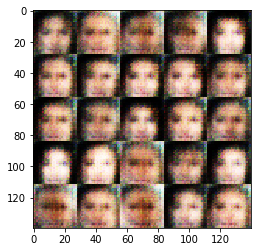

Epoch 0: Step:1250 d_loss:1.540031909942627 g_loss:0.8085267543792725
Epoch 0: Step:1300 d_loss:1.380474328994751 g_loss:0.8621782064437866
Epoch 0: Step:1350 d_loss:0.8909870386123657 g_loss:1.2874382734298706


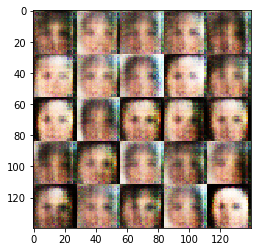

Epoch 0: Step:1400 d_loss:1.7263624668121338 g_loss:0.6908795833587646
Epoch 0: Step:1450 d_loss:1.3067657947540283 g_loss:0.9225724935531616
Epoch 0: Step:1500 d_loss:1.3253562450408936 g_loss:0.8260534405708313


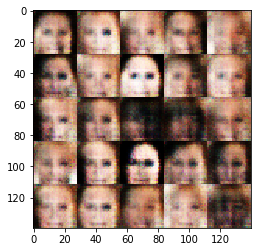

Epoch 0: Step:1550 d_loss:1.5120573043823242 g_loss:0.8760266900062561
Epoch 0: Step:1600 d_loss:1.3461122512817383 g_loss:1.0095900297164917
Epoch 0: Step:1650 d_loss:1.0905563831329346 g_loss:1.2751286029815674


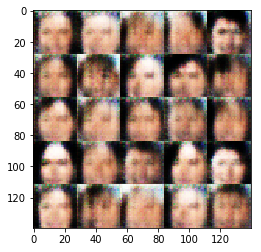

Epoch 0: Step:1700 d_loss:1.3870441913604736 g_loss:1.1283977031707764
Epoch 0: Step:1750 d_loss:1.286919116973877 g_loss:0.768952488899231
Epoch 0: Step:1800 d_loss:1.447619915008545 g_loss:0.6411908864974976


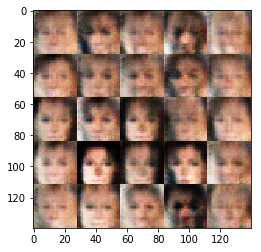

Epoch 0: Step:1850 d_loss:1.3891716003417969 g_loss:0.8589544296264648
Epoch 0: Step:1900 d_loss:1.3020620346069336 g_loss:0.8395770788192749
Epoch 0: Step:1950 d_loss:1.278542399406433 g_loss:1.1701390743255615


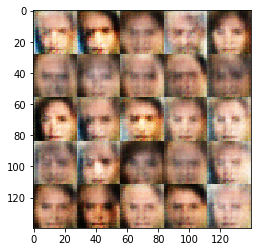

Epoch 0: Step:2000 d_loss:1.513352394104004 g_loss:0.9456689357757568
Epoch 0: Step:2050 d_loss:1.338577151298523 g_loss:0.9241880178451538
Epoch 0: Step:2100 d_loss:1.3256962299346924 g_loss:0.7857626676559448


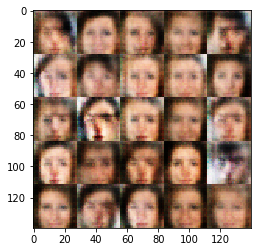

Epoch 0: Step:2150 d_loss:1.216533899307251 g_loss:0.8947580456733704
Epoch 0: Step:2200 d_loss:1.4307339191436768 g_loss:0.8083332777023315
Epoch 0: Step:2250 d_loss:1.4103970527648926 g_loss:0.7738398313522339


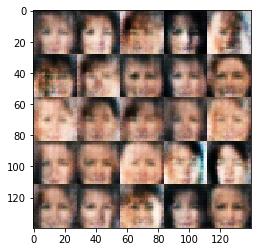

Epoch 0: Step:2300 d_loss:1.4814200401306152 g_loss:0.9156653881072998
Epoch 0: Step:2350 d_loss:1.3050421476364136 g_loss:1.1029075384140015
Epoch 0: Step:2400 d_loss:1.6378262042999268 g_loss:0.7097450494766235


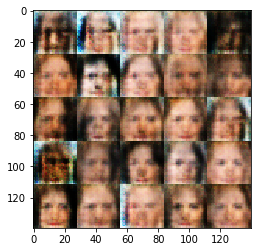

Epoch 0: Step:2450 d_loss:1.5772793292999268 g_loss:0.6751716136932373
Epoch 0: Step:2500 d_loss:1.3916046619415283 g_loss:0.9721640348434448
Epoch 0: Step:2550 d_loss:1.3989503383636475 g_loss:0.9754294157028198


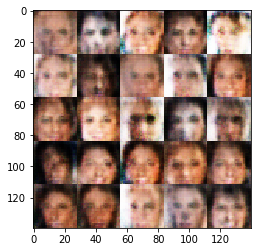

Epoch 0: Step:2600 d_loss:1.5823464393615723 g_loss:0.8346883654594421
Epoch 0: Step:2650 d_loss:1.5856136083602905 g_loss:0.740484356880188
Epoch 0: Step:2700 d_loss:1.5750815868377686 g_loss:0.7378076314926147


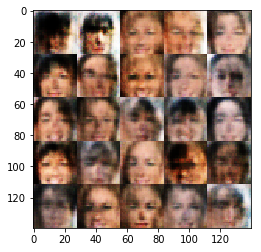

Epoch 0: Step:2750 d_loss:1.4393510818481445 g_loss:0.8219707608222961
Epoch 0: Step:2800 d_loss:1.5209101438522339 g_loss:0.6561609506607056
Epoch 0: Step:2850 d_loss:1.6631345748901367 g_loss:0.5753732919692993


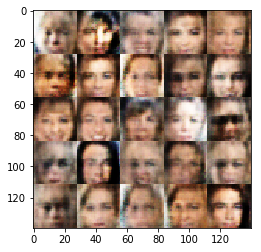

Epoch 0: Step:2900 d_loss:1.5683984756469727 g_loss:0.566225528717041
Epoch 0: Step:2950 d_loss:1.408208966255188 g_loss:0.7318255305290222
Epoch 0: Step:3000 d_loss:1.3208544254302979 g_loss:0.8291565179824829


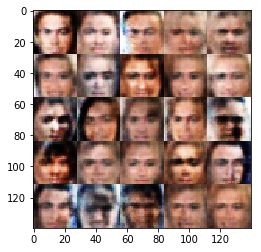

Epoch 0: Step:3050 d_loss:1.788588285446167 g_loss:0.5455166101455688
Epoch 0: Step:3100 d_loss:1.4026488065719604 g_loss:0.8117324113845825
Epoch 0: Step:3150 d_loss:1.4919610023498535 g_loss:0.6473198533058167


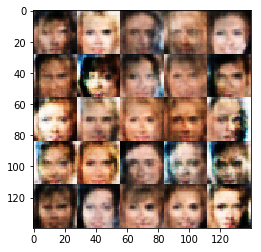

Epoch 0: Step:3200 d_loss:1.4994306564331055 g_loss:0.7501893043518066
Epoch 0: Step:3250 d_loss:1.2682321071624756 g_loss:0.9260408878326416
Epoch 0: Step:3300 d_loss:1.664522647857666 g_loss:0.6771481037139893


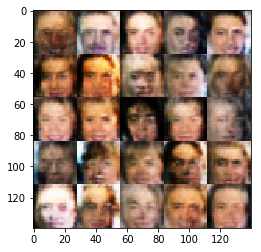

Epoch 0: Step:3350 d_loss:1.5308818817138672 g_loss:0.6395896673202515
Epoch 0: Step:3400 d_loss:1.3758574724197388 g_loss:0.7919412851333618
Epoch 0: Step:3450 d_loss:1.2214903831481934 g_loss:0.7296427488327026


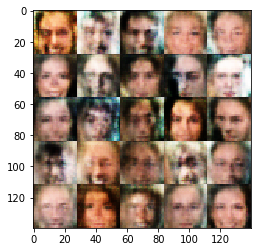

Epoch 0: Step:3500 d_loss:1.4876937866210938 g_loss:0.7008076906204224
Epoch 0: Step:3550 d_loss:1.5764760971069336 g_loss:0.5788933038711548
Epoch 0: Step:3600 d_loss:1.4309988021850586 g_loss:0.7327829003334045


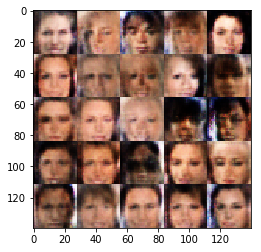

Epoch 0: Step:3650 d_loss:1.351845383644104 g_loss:0.8004659414291382
Epoch 0: Step:3700 d_loss:1.447153091430664 g_loss:0.7325419187545776
Epoch 0: Step:3750 d_loss:1.542785406112671 g_loss:0.6460771560668945


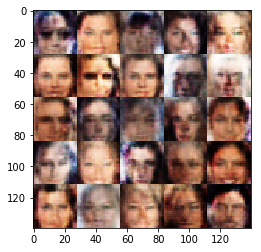

Epoch 0: Step:3800 d_loss:1.387608289718628 g_loss:0.7968234419822693
Epoch 0: Step:3850 d_loss:1.3659086227416992 g_loss:0.7327494621276855
Epoch 0: Step:3900 d_loss:1.3993254899978638 g_loss:0.6624325513839722


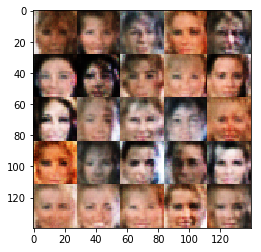

Epoch 0: Step:3950 d_loss:1.3908815383911133 g_loss:0.7590582370758057
Epoch 0: Step:4000 d_loss:1.3964457511901855 g_loss:0.756713330745697
Epoch 0: Step:4050 d_loss:1.4565248489379883 g_loss:0.7483924627304077


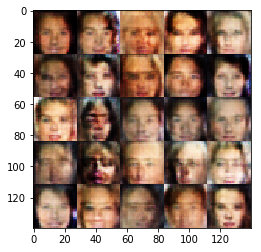

Epoch 0: Step:4100 d_loss:1.41648268699646 g_loss:0.7083673477172852
Epoch 0: Step:4150 d_loss:1.4125902652740479 g_loss:0.7064706087112427
Epoch 0: Step:4200 d_loss:1.3737729787826538 g_loss:0.6860606670379639


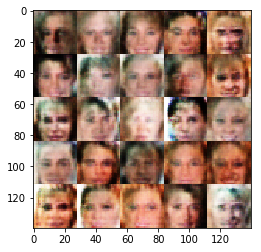

Epoch 0: Step:4250 d_loss:1.4906091690063477 g_loss:0.739264726638794
Epoch 0: Step:4300 d_loss:1.449156403541565 g_loss:0.6161187291145325
Epoch 0: Step:4350 d_loss:1.3591523170471191 g_loss:0.7474159002304077


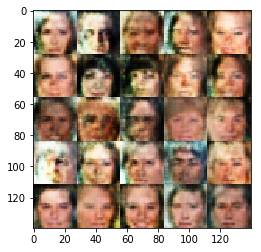

Epoch 0: Step:4400 d_loss:1.4891411066055298 g_loss:0.7000393867492676
Epoch 0: Step:4450 d_loss:1.4694676399230957 g_loss:0.6686478853225708
Epoch 0: Step:4500 d_loss:1.5515488386154175 g_loss:0.7371019124984741


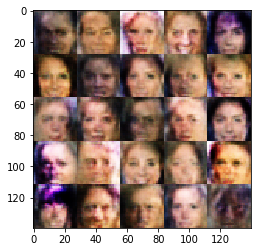

Epoch 0: Step:4550 d_loss:1.4772388935089111 g_loss:0.7338687777519226
Epoch 0: Step:4600 d_loss:1.3943703174591064 g_loss:0.7790040373802185
Epoch 0: Step:4650 d_loss:1.4960646629333496 g_loss:0.6566101908683777


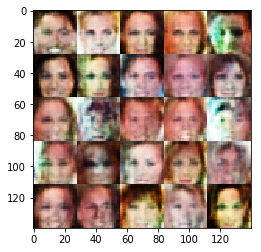

Epoch 0: Step:4700 d_loss:1.3406473398208618 g_loss:0.7636654376983643
Epoch 0: Step:4750 d_loss:1.3803356885910034 g_loss:0.7313064932823181
Epoch 0: Step:4800 d_loss:1.3803181648254395 g_loss:0.7387251257896423


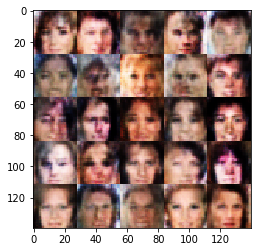

Epoch 0: Step:4850 d_loss:1.3147432804107666 g_loss:0.8204054832458496
Epoch 0: Step:4900 d_loss:1.4444653987884521 g_loss:0.6928567886352539
Epoch 0: Step:4950 d_loss:1.4359313249588013 g_loss:0.7849987745285034


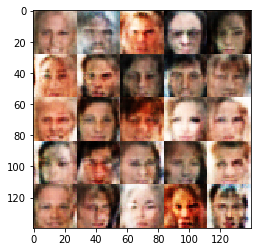

Epoch 0: Step:5000 d_loss:1.4168541431427002 g_loss:0.7571282982826233
Epoch 0: Step:5050 d_loss:1.5838844776153564 g_loss:0.6502108573913574
Epoch 0: Step:5100 d_loss:1.5265419483184814 g_loss:0.5902372598648071


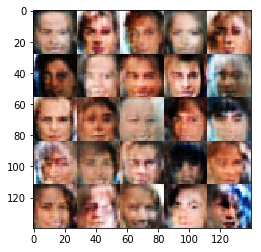

Epoch 0: Step:5150 d_loss:1.5501391887664795 g_loss:0.649833083152771
Epoch 0: Step:5200 d_loss:1.579538345336914 g_loss:0.6174842119216919
Epoch 0: Step:5250 d_loss:1.5063247680664062 g_loss:0.6337815523147583


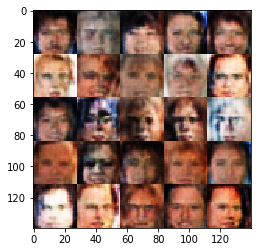

Epoch 0: Step:5300 d_loss:1.4376360177993774 g_loss:0.6501047611236572
Epoch 0: Step:5350 d_loss:1.460760235786438 g_loss:0.7589908838272095
Epoch 0: Step:5400 d_loss:1.5164457559585571 g_loss:0.6589237451553345


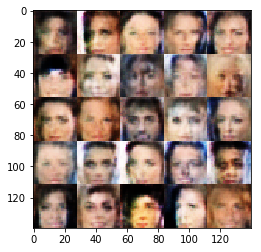

Epoch 0: Step:5450 d_loss:1.393652319908142 g_loss:0.7130182981491089
Epoch 0: Step:5500 d_loss:1.4940900802612305 g_loss:0.6816214323043823
Epoch 0: Step:5550 d_loss:1.2905211448669434 g_loss:0.7778043150901794


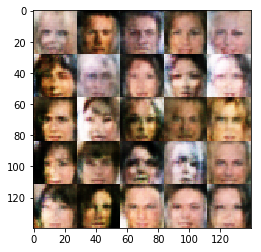

Epoch 0: Step:5600 d_loss:1.4421603679656982 g_loss:0.6623431444168091
Epoch 0: Step:5650 d_loss:1.4425171613693237 g_loss:0.6703674793243408
Epoch 0: Step:5700 d_loss:1.3859503269195557 g_loss:0.7317540049552917


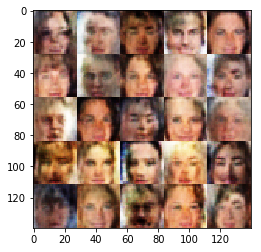

Epoch 0: Step:5750 d_loss:1.3917021751403809 g_loss:0.74915611743927
Epoch 0: Step:5800 d_loss:1.4640204906463623 g_loss:0.7383649349212646
Epoch 0: Step:5850 d_loss:1.4389472007751465 g_loss:0.6766915321350098


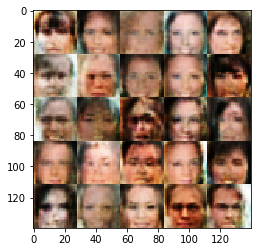

Epoch 0: Step:5900 d_loss:1.4694299697875977 g_loss:0.6608955264091492
Epoch 0: Step:5950 d_loss:1.4288371801376343 g_loss:0.6918569207191467
Epoch 0: Step:6000 d_loss:1.4101994037628174 g_loss:0.7159379720687866


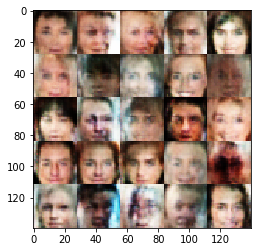

Epoch 0: Step:6050 d_loss:1.353363037109375 g_loss:0.6863628625869751
Epoch 0: Step:6100 d_loss:1.3959671258926392 g_loss:0.7303892374038696
Epoch 0: Step:6150 d_loss:1.4252283573150635 g_loss:0.7615294456481934


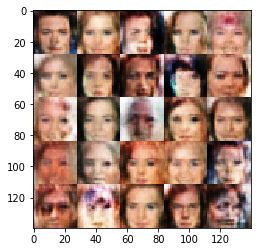

Epoch 0: Step:6200 d_loss:1.4531358480453491 g_loss:0.703287661075592
Epoch 0: Step:6250 d_loss:1.380082130432129 g_loss:0.752526044845581
Epoch 0: Step:6300 d_loss:1.312601089477539 g_loss:0.6833410263061523


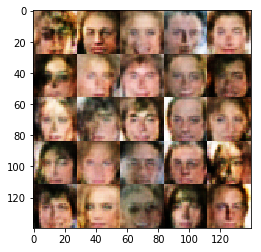

Epoch 0: Step:6350 d_loss:1.3985838890075684 g_loss:0.7536621689796448
Epoch 0: Step:6400 d_loss:1.4129139184951782 g_loss:0.7283419966697693
Epoch 0: Step:6450 d_loss:1.3232197761535645 g_loss:0.7884632349014282


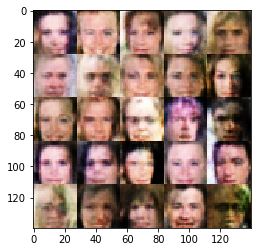

Epoch 0: Step:6500 d_loss:1.3621937036514282 g_loss:0.7513314485549927
Epoch 0: Step:6550 d_loss:1.3767145872116089 g_loss:0.7244442105293274
Epoch 0: Step:6600 d_loss:1.4420686960220337 g_loss:0.7088043093681335


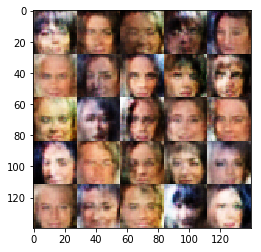

Epoch 0: Step:6650 d_loss:1.412928581237793 g_loss:0.6751622557640076
Epoch 0: Step:6700 d_loss:1.398728370666504 g_loss:0.7830760478973389
Epoch 0: Step:6750 d_loss:1.3720405101776123 g_loss:0.7068580389022827


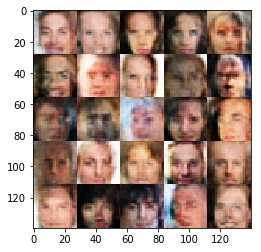

Epoch 0: Step:6800 d_loss:1.447277545928955 g_loss:0.7042425870895386
Epoch 0: Step:6850 d_loss:1.5305103063583374 g_loss:0.6642380952835083
Epoch 0: Step:6900 d_loss:1.4296681880950928 g_loss:0.711296796798706


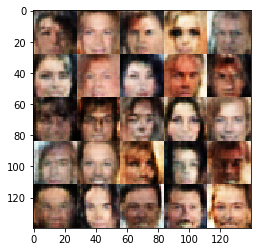

Epoch 0: Step:6950 d_loss:1.4374547004699707 g_loss:0.6474109888076782
Epoch 0: Step:7000 d_loss:1.504366159439087 g_loss:0.6970723867416382
Epoch 0: Step:7050 d_loss:1.4240622520446777 g_loss:0.6463979482650757


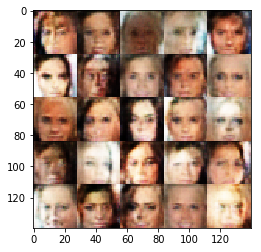

Epoch 0: Step:7100 d_loss:1.3438971042633057 g_loss:0.7158406376838684
Epoch 0: Step:7150 d_loss:1.4874975681304932 g_loss:0.657261312007904
Epoch 0: Step:7200 d_loss:1.4867305755615234 g_loss:0.5984650254249573


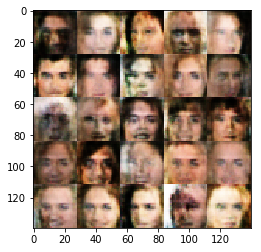

Epoch 0: Step:7250 d_loss:1.3825082778930664 g_loss:0.6526485681533813
Epoch 0: Step:7300 d_loss:1.4413583278656006 g_loss:0.6713365316390991
Epoch 0: Step:7350 d_loss:1.5092008113861084 g_loss:0.6118160486221313


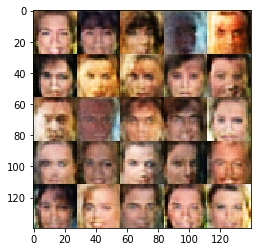

Epoch 0: Step:7400 d_loss:1.5072455406188965 g_loss:0.6047819256782532
Epoch 0: Step:7450 d_loss:1.3392713069915771 g_loss:0.6896926164627075
Epoch 0: Step:7500 d_loss:1.5058025121688843 g_loss:0.598966121673584


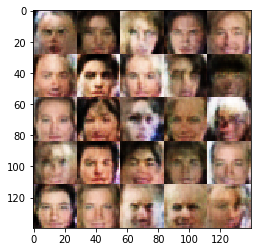

Epoch 0: Step:7550 d_loss:1.3485689163208008 g_loss:0.7239158153533936
Epoch 0: Step:7600 d_loss:1.4420616626739502 g_loss:0.6807281970977783
Epoch 0: Step:7650 d_loss:1.322615385055542 g_loss:0.7487500905990601


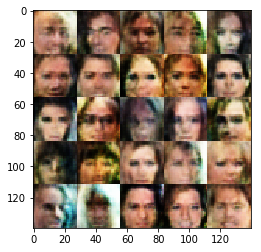

Epoch 0: Step:7700 d_loss:1.405897855758667 g_loss:0.629170298576355
Epoch 0: Step:7750 d_loss:1.4168416261672974 g_loss:0.66327965259552
Epoch 0: Step:7800 d_loss:1.4432363510131836 g_loss:0.6253090500831604


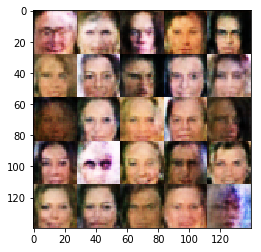

Epoch 0: Step:7850 d_loss:1.452280044555664 g_loss:0.729454755783081
Epoch 0: Step:7900 d_loss:1.3672269582748413 g_loss:0.7463700771331787
Epoch 0: Step:7950 d_loss:1.3957362174987793 g_loss:0.6827694177627563


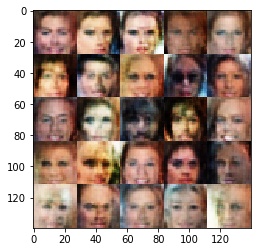

Epoch 0: Step:8000 d_loss:1.4211528301239014 g_loss:0.620362401008606
Epoch 0: Step:8050 d_loss:1.4329538345336914 g_loss:0.6717239618301392
Epoch 0: Step:8100 d_loss:1.5263314247131348 g_loss:0.6099975109100342


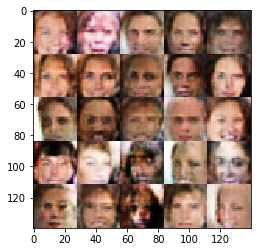

Epoch 0: Step:8150 d_loss:1.4289995431900024 g_loss:0.6781051754951477
Epoch 0: Step:8200 d_loss:1.3862159252166748 g_loss:0.6970458030700684
Epoch 0: Step:8250 d_loss:1.4675414562225342 g_loss:0.6791102886199951


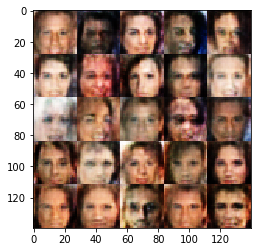

Epoch 0: Step:8300 d_loss:1.4604414701461792 g_loss:0.6392619609832764
Epoch 0: Step:8350 d_loss:1.3705496788024902 g_loss:0.6732760071754456
Epoch 0: Step:8400 d_loss:1.3754119873046875 g_loss:0.7447050213813782


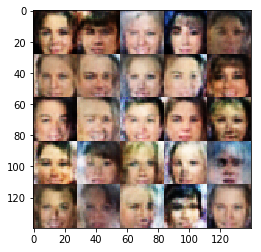

Epoch 0: Step:8450 d_loss:1.4066423177719116 g_loss:0.681297779083252
Epoch 0: Step:8500 d_loss:1.316209316253662 g_loss:0.7693055868148804
Epoch 0: Step:8550 d_loss:1.4260201454162598 g_loss:0.6781413555145264


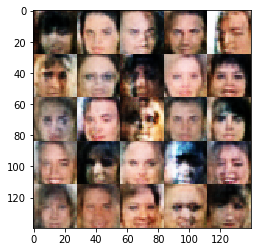

Epoch 0: Step:8600 d_loss:1.4515259265899658 g_loss:0.6543893814086914
Epoch 0: Step:8650 d_loss:1.3835594654083252 g_loss:0.7141275405883789
Epoch 0: Step:8700 d_loss:1.4070630073547363 g_loss:0.7158616781234741


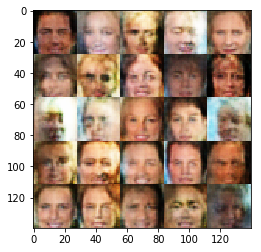

Epoch 0: Step:8750 d_loss:1.3304657936096191 g_loss:0.7601684331893921
Epoch 0: Step:8800 d_loss:1.340693712234497 g_loss:0.724941611289978
Epoch 0: Step:8850 d_loss:1.4104113578796387 g_loss:0.6467856168746948


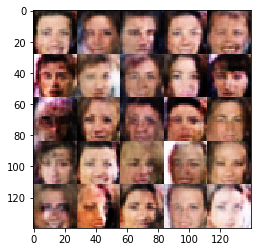

Epoch 0: Step:8900 d_loss:1.4537869691848755 g_loss:0.6708024740219116
Epoch 0: Step:8950 d_loss:1.4256393909454346 g_loss:0.7023701071739197
Epoch 0: Step:9000 d_loss:1.4025828838348389 g_loss:0.7651754021644592


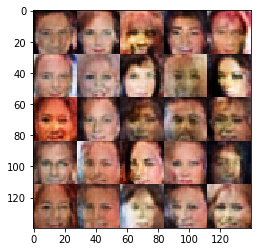

Epoch 0: Step:9050 d_loss:1.416435956954956 g_loss:0.7066586017608643
Epoch 0: Step:9100 d_loss:1.4385724067687988 g_loss:0.6738021969795227
Epoch 0: Step:9150 d_loss:1.3325166702270508 g_loss:0.7762326002120972


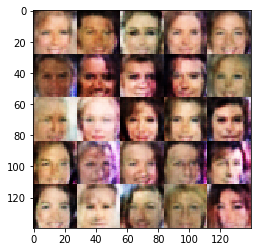

Epoch 0: Step:9200 d_loss:1.4691781997680664 g_loss:0.6934998035430908
Epoch 0: Step:9250 d_loss:1.3692840337753296 g_loss:0.700989842414856
Epoch 0: Step:9300 d_loss:1.4753813743591309 g_loss:0.6087233424186707


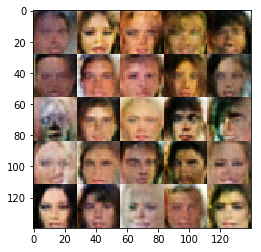

Epoch 0: Step:9350 d_loss:1.4589921236038208 g_loss:0.6242483258247375
Epoch 0: Step:9400 d_loss:1.4382190704345703 g_loss:0.6958147287368774
Epoch 0: Step:9450 d_loss:1.4066824913024902 g_loss:0.6954759359359741


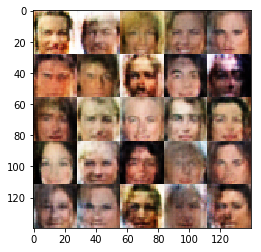

Epoch 0: Step:9500 d_loss:1.4016555547714233 g_loss:0.6414302587509155
Epoch 0: Step:9550 d_loss:1.390638828277588 g_loss:0.6744957566261292
Epoch 0: Step:9600 d_loss:1.3361053466796875 g_loss:0.7205970883369446


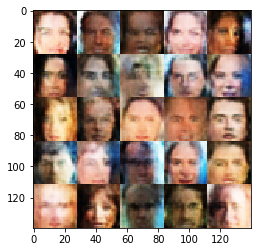

Epoch 0: Step:9650 d_loss:1.374204158782959 g_loss:0.701415479183197
Epoch 0: Step:9700 d_loss:1.3789480924606323 g_loss:0.7420881986618042
Epoch 0: Step:9750 d_loss:1.4140591621398926 g_loss:0.6794080138206482


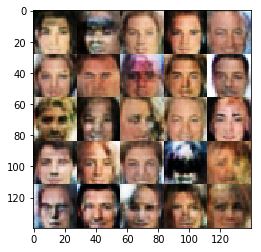

Epoch 0: Step:9800 d_loss:1.4538679122924805 g_loss:0.6616528630256653
Epoch 0: Step:9850 d_loss:1.4893908500671387 g_loss:0.6522942781448364
Epoch 0: Step:9900 d_loss:1.401455283164978 g_loss:0.6903204917907715


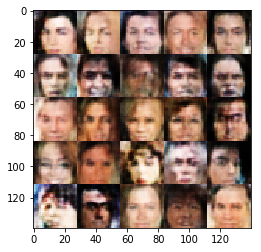

Epoch 0: Step:9950 d_loss:1.3587838411331177 g_loss:0.6909637451171875
Epoch 0: Step:10000 d_loss:1.4473122358322144 g_loss:0.6659190654754639
Epoch 0: Step:10050 d_loss:1.3532570600509644 g_loss:0.7442342042922974


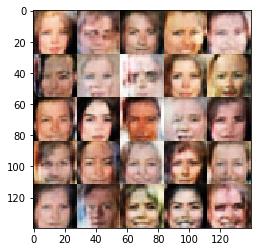

Epoch 0: Step:10100 d_loss:1.4966273307800293 g_loss:0.684802770614624
Epoch 0: Step:10150 d_loss:1.4708969593048096 g_loss:0.6391583681106567
Epoch 0: Step:10200 d_loss:1.3782466650009155 g_loss:0.7045632600784302


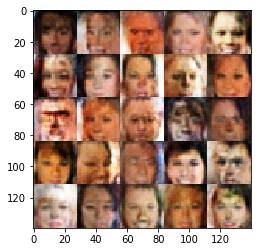

Epoch 0: Step:10250 d_loss:1.4511871337890625 g_loss:0.6301771402359009
Epoch 0: Step:10300 d_loss:1.3127570152282715 g_loss:0.7267147898674011
Epoch 0: Step:10350 d_loss:1.389674425125122 g_loss:0.6658297777175903


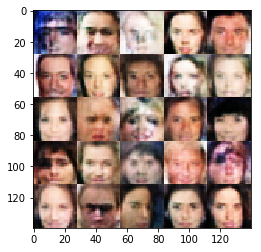

Epoch 0: Step:10400 d_loss:1.4324085712432861 g_loss:0.7125082612037659
Epoch 0: Step:10450 d_loss:1.3795688152313232 g_loss:0.7226606607437134
Epoch 0: Step:10500 d_loss:1.371809720993042 g_loss:0.6785714626312256


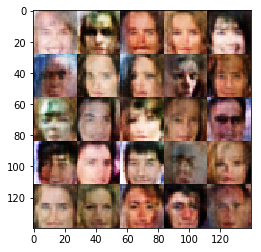

Epoch 0: Step:10550 d_loss:1.3940582275390625 g_loss:0.6999392509460449
Epoch 0: Step:10600 d_loss:1.4231922626495361 g_loss:0.6538771986961365
Epoch 0: Step:10650 d_loss:1.35451078414917 g_loss:0.6955724954605103


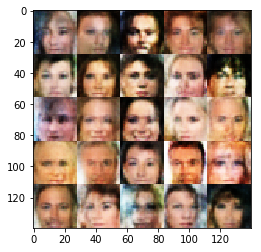

Epoch 0: Step:10700 d_loss:1.4209418296813965 g_loss:0.6987370252609253
Epoch 0: Step:10750 d_loss:1.3120520114898682 g_loss:0.7151103019714355
Epoch 0: Step:10800 d_loss:1.4356194734573364 g_loss:0.6729298233985901


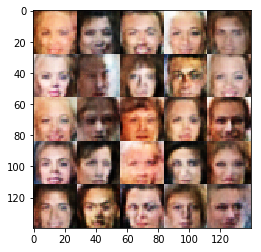

Epoch 0: Step:10850 d_loss:1.4263147115707397 g_loss:0.6799087524414062
Epoch 0: Step:10900 d_loss:1.4187695980072021 g_loss:0.6684209108352661
Epoch 0: Step:10950 d_loss:1.42586088180542 g_loss:0.677174985408783


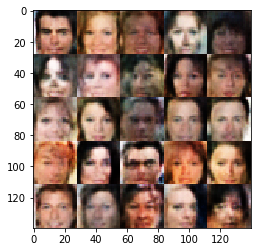

Epoch 0: Step:11000 d_loss:1.397840976715088 g_loss:0.6954593062400818
Epoch 0: Step:11050 d_loss:1.3811419010162354 g_loss:0.7607018351554871
Epoch 0: Step:11100 d_loss:1.4159233570098877 g_loss:0.7195256352424622


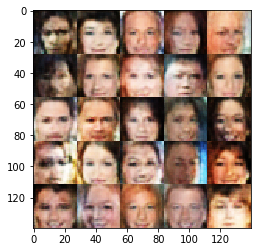

Epoch 0: Step:11150 d_loss:1.3756067752838135 g_loss:0.658804178237915
Epoch 0: Step:11200 d_loss:1.4391555786132812 g_loss:0.6389490962028503
Epoch 0: Step:11250 d_loss:1.4012033939361572 g_loss:0.7133141756057739


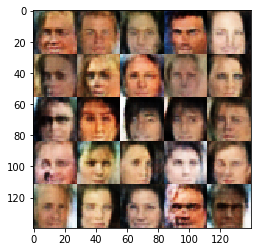

Epoch 0: Step:11300 d_loss:1.3610775470733643 g_loss:0.7220374345779419
Epoch 0: Step:11350 d_loss:1.4391155242919922 g_loss:0.6593945026397705
Epoch 0: Step:11400 d_loss:1.408475637435913 g_loss:0.6773775219917297


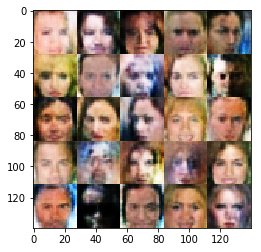

Epoch 0: Step:11450 d_loss:1.4387271404266357 g_loss:0.6660095453262329
Epoch 0: Step:11500 d_loss:1.368302822113037 g_loss:0.7183563709259033
Epoch 0: Step:11550 d_loss:1.3708800077438354 g_loss:0.7154132723808289


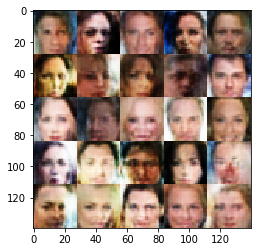

Epoch 0: Step:11600 d_loss:1.387995958328247 g_loss:0.7322289347648621
Epoch 0: Step:11650 d_loss:1.5057824850082397 g_loss:0.6363723278045654
Epoch 0: Step:11700 d_loss:1.4255781173706055 g_loss:0.6974496841430664


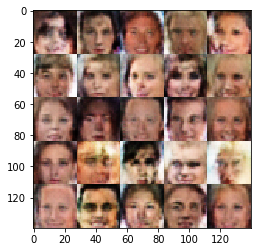

Epoch 0: Step:11750 d_loss:1.3642940521240234 g_loss:0.6788375973701477
Epoch 0: Step:11800 d_loss:1.4486043453216553 g_loss:0.7091014981269836
Epoch 0: Step:11850 d_loss:1.376763105392456 g_loss:0.6902803182601929


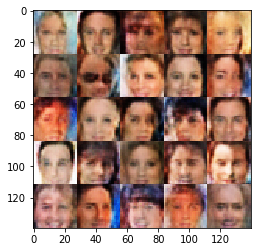

Epoch 0: Step:11900 d_loss:1.418033242225647 g_loss:0.6970740556716919
Epoch 0: Step:11950 d_loss:1.359869360923767 g_loss:0.7153981328010559
Epoch 0: Step:12000 d_loss:1.4401285648345947 g_loss:0.6445325613021851


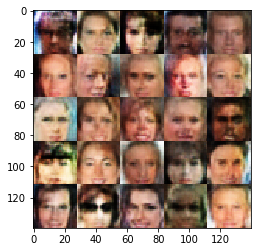

Epoch 0: Step:12050 d_loss:1.39314866065979 g_loss:0.6900007724761963
Epoch 0: Step:12100 d_loss:1.4227484464645386 g_loss:0.6956790089607239
Epoch 0: Step:12150 d_loss:1.4061450958251953 g_loss:0.6629651784896851


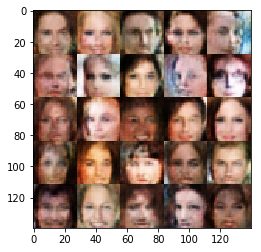

Epoch 0: Step:12200 d_loss:1.3925340175628662 g_loss:0.7046518325805664
Epoch 0: Step:12250 d_loss:1.4282150268554688 g_loss:0.6758887767791748
Epoch 0: Step:12300 d_loss:1.3575509786605835 g_loss:0.6961262226104736


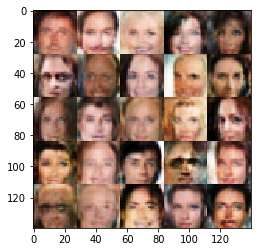

Epoch 0: Step:12350 d_loss:1.4074071645736694 g_loss:0.690731406211853
Epoch 0: Step:12400 d_loss:1.3666820526123047 g_loss:0.7033083438873291
Epoch 0: Step:12450 d_loss:1.5194201469421387 g_loss:0.6124711036682129


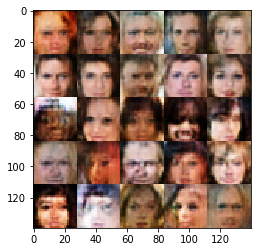

Epoch 0: Step:12500 d_loss:1.3779712915420532 g_loss:0.6809718608856201
Epoch 0: Step:12550 d_loss:1.3981246948242188 g_loss:0.6677861213684082
Epoch 0: Step:12600 d_loss:1.4520103931427002 g_loss:0.6673692464828491


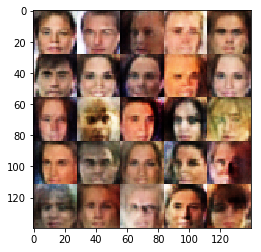

Epoch 0: Step:12650 d_loss:1.466261863708496 g_loss:0.6420513391494751


In [20]:
batch_size = 16
z_dim = 100
learning_rate = 0.00005
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.